In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, pack_dataset, Workspace
from scalebars import *
import deconv

import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.001  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

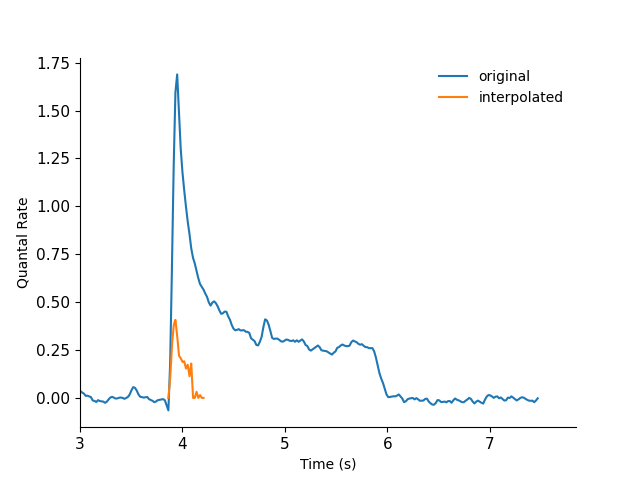

In [5]:
trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [6]:
model_path = os.path.join(base_path, "model_runs", "ball_stick")
save_name = "test"
load_name = None
# load_name = "control"

model_config = configs.ball_stick_config(
    ttx=False,
    poisson_rates={"sac": vrate * 1., "glut": vrate * 1., "dt": target_rate_dt},
)

model_config["time_rho"] = 0.9

# model_config["synprops"]["E"]["weight"] = model_config["synprops"]["E"]["weight"] * 4
model_config["synprops"]["E"]["tau2"] = 0.54
# model_config["synprops"]["E"]["tau2"] = 0.4
# model_config["synprops"]["NMDA"]["pref_prob"] = 0.0
# model_config["synprops"]["NMDA"]["null_prob"] = 0.0
    
if load_name is None:
    from balance_compartment_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    model = Model(model_config)
    runner = Rig(model)
    res = {}
    n_trials = 3
    rhos = [0., 0.9]
    
    for rho in rhos:
        res[rho] = runner.dir_run(
            n_trials, rhos={"time": rho, "space": rho}, save_name=None, plot_summary=False, quiet=True
        )
        
    with h5.File(save_path, "w") as pckg:
        data = {r: {0: res[r]} for r in res.keys()}
        pack_dataset(pckg, data, compression=None)
        del data, res


hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
        
# TODO: in order to take advantage of (some) of the same analysis functions I should just store the data
# for this as though it is a single network run (one idx of 0)
rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())
print("==keys==")
print("rhos:", rhos)
print("idxs:", idxs)

In [7]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [8]:
metrics = ana.get_sac_metrics(d)

dir_labels = d[rhos[0]][idxs[0]]["params"]["dir_labels"][:]
# tuning = ana.analyze_tree(d, dir_labels, pref=0, thresh=-56)
# sac_thetas = ana.get_sac_thetas(d)
# sac_deltas = ana.get_sac_deltas(sac_thetas)

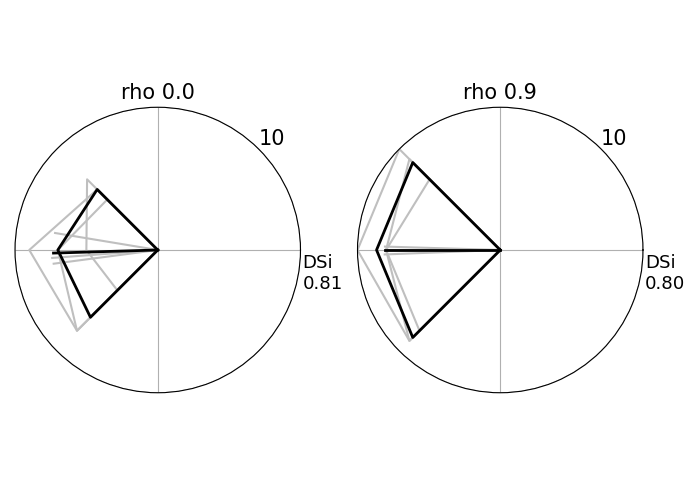

In [9]:
max_spikes = np.max([r["spikes"] for r in metrics.values()])
polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
polar_ax = [
    polar_plot(
        m,
        dir_labels,
        title="rho " + str(r),
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=polar_fig,
        sub_loc=(1, n_cols, loc + 1),
        title_metrics=False,
    )
    for loc, (r, m) in enumerate(metrics.items())
]
polar_fig.tight_layout()

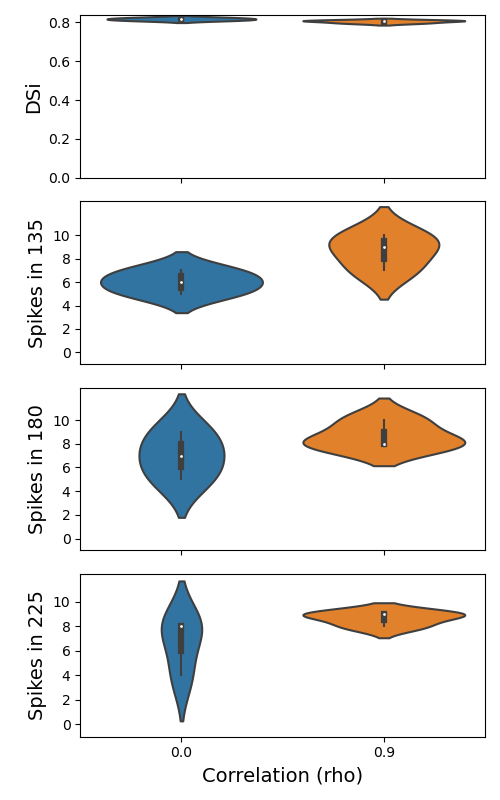

In [10]:
violins = sac_rho_violins(metrics, dir_labels, figsize=(5, 8))

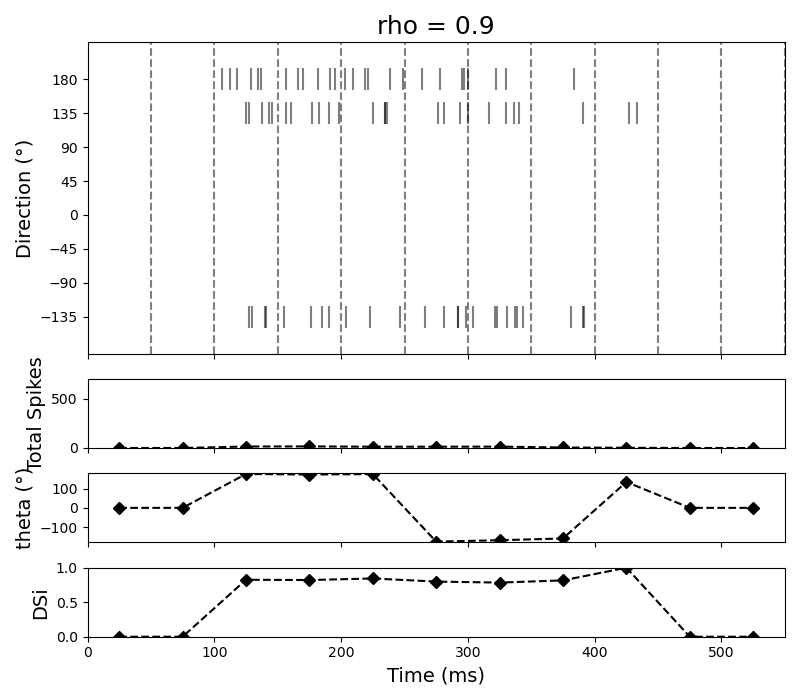

In [12]:
dir_field_offsets = [11.0, 18.8, 37.8, 13.8, 0.8, 19.3, 16.0, 0.0]  # ms
rasters_fig = spike_rasters(
    d,
    dir_labels,
    rho=0.9,
    bin_ms=50,
    offsets=dir_field_offsets,
    colour="black",
    spike_vmax=700,
    figsize=(8, 7),
)

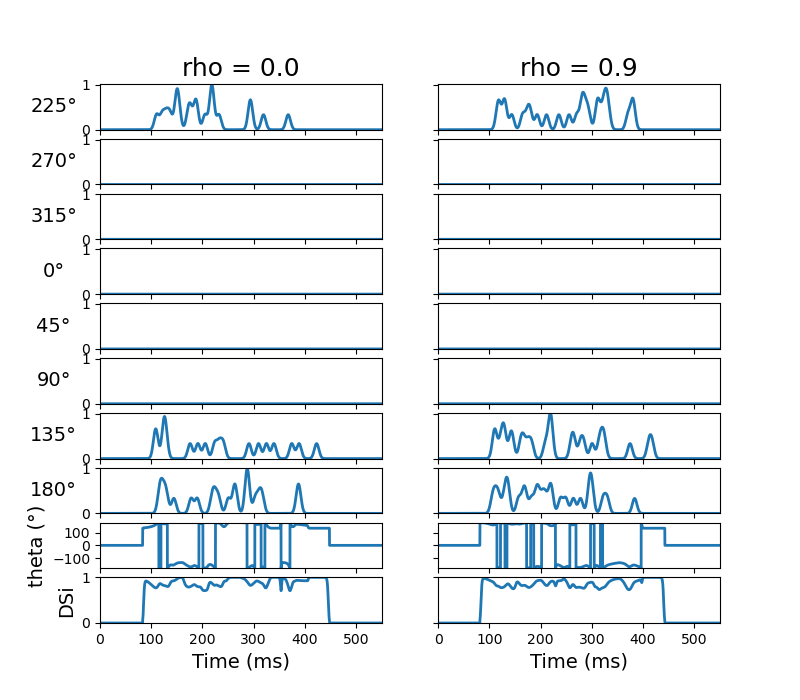

In [13]:
evol = time_evolution(d, dir_labels, kernel_var=45, figsize=(8, 7))

In [18]:
close_button()

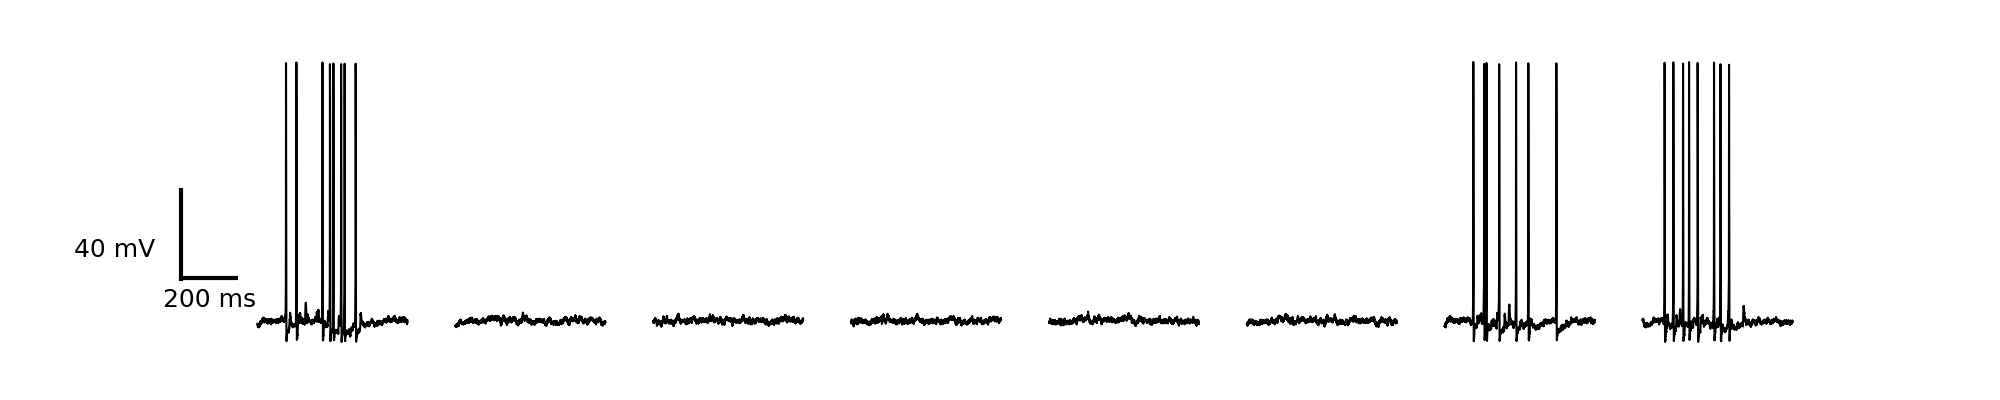

In [17]:
rho = 0.9
net = 0
trial = 0

vm_pts = d[rho][net]["soma"]["Vm"].shape[-1]
vm_xaxis = np.linspace(0, vm_pts * d[rho][net]["params"]["dt"], vm_pts)

trial_vm_fig, trial_vm_ax = plt.subplots(1, len(dir_labels), sharex=True, sharey=True, figsize=(20, 4))
for i in range(len(dir_labels)):
    trial_vm_ax[i].plot(vm_xaxis[300:], d[rho][net]["soma"]["Vm"][trial, i, 300:], c="black")

clean_axes(trial_vm_ax, remove_spines=["left", "right", "top", "bottom"])

sizex = 200
sizey = 40
add_scalebar(
    trial_vm_ax[0], 
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % sizex,
    labely="%i mV" % sizey,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 150),
    textprops={"fontsize": 18},
)

In [20]:
# list(d[1.0][0]["soma"]["Vm"].shape